# **Market Order vs. Limit Order**

1. A limit order allows you to buy or sell an asset at a predetermined price.
Given that you have to wait in a queue; the first orders that join the limit
order book is executed first in a FIFO style queue.

  Benefit/Drawback : You are able to execute an order at the price you
want, but you have to wait for orders in front of you to execute first.
Sometimes you wait 1 second, 1 minute or ... for eternity (will explain).

2. A market order allows you to buy or sell an asset immediately, but the
price is variable depending on the available liquidity.

  Benefit/Drawback : You are able to execute an order immediately, but
at a price you can’t decide.

# **Slippage and Temporary Impact Function**
slippage: how much ”worse” it costed to execute the order with respect to the mid price.

temporary impact function $g_t(X)$: the amount of slippage
you incur if you place X orders at the current time t.

Consider each one-minute trading period, added and cancelled limit orders and market orders can change the order book and the mid price. To deal with the changing order book and mid price, we can use

1. fixed: Use the order book and mid price at the first snapshot of each one-minute trading period
2. average: Calculate the mid price when each limit order is placed and average over the one-minute trading period. Used the average mid price and the order book at the first snapshot of each one-minute trading period
3. high frequency: Everytime the limit order is placed, use the order book and the mid price to calculate corresponding slippage

For simplicity, I just use the order book and mid price at the first snapshot of each one-minute trading period to calculate the slippage (assuming we are placing a buy-side market order of size X)

In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# read the limit order book
LOB_SOUN = pd.read_csv('/content/SOUN_2025-04-03 00_00_00+00_00.csv', parse_dates=["ts_event"])
LOB_FROG = pd.read_csv('/content/FROG_2025-04-03 00_00_00+00_00.csv', parse_dates=["ts_event"])
LOB_CRWV = pd.read_csv('/content/CRWV_2025-04-03 00_00_00+00_00.csv', parse_dates=["ts_event"])
Data = [(LOB_SOUN, 'SOUN'), (LOB_FROG,'FROG'), (LOB_CRWV,'CRWV')]

In [28]:
# define the function to calculate slippage
def compute_slippage(ask_prices, ask_sizes, mid_price, X):
    total_cost = 0
    filled = 0
    for price, size in zip(ask_prices, ask_sizes):
        if filled >= X:
            break
        take = min(size, X - filled)
        total_cost += take * (price - mid_price)
        filled += take
    if filled < X:
        return None  # insufficient liquidity
    return total_cost / X

**First we consider linearize the temporary impact**


[SOUN] average linear slippage beta: 0.0000009344
[SOUN] average R^2 using average beta across all snapshots: -2.6969


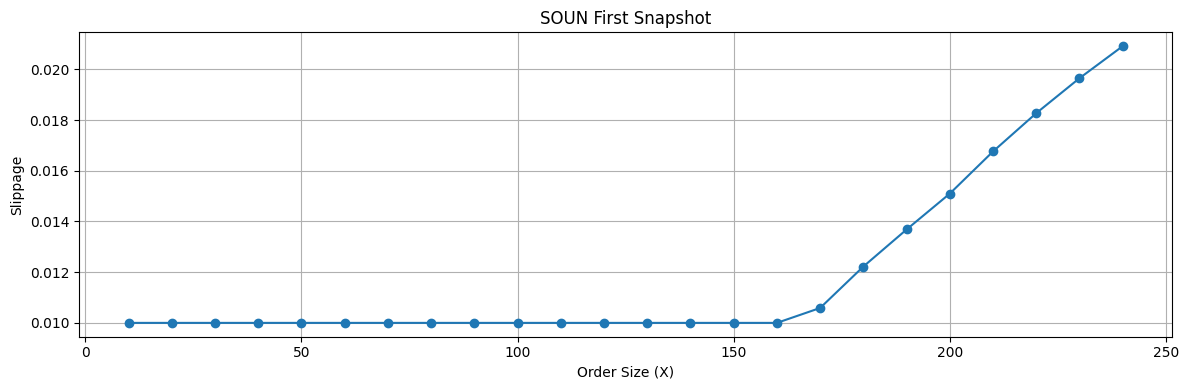


[FROG] average linear slippage beta: 0.0000397615
[FROG] average R^2 using average beta across all snapshots: -4234075253873901071605665103872.0000


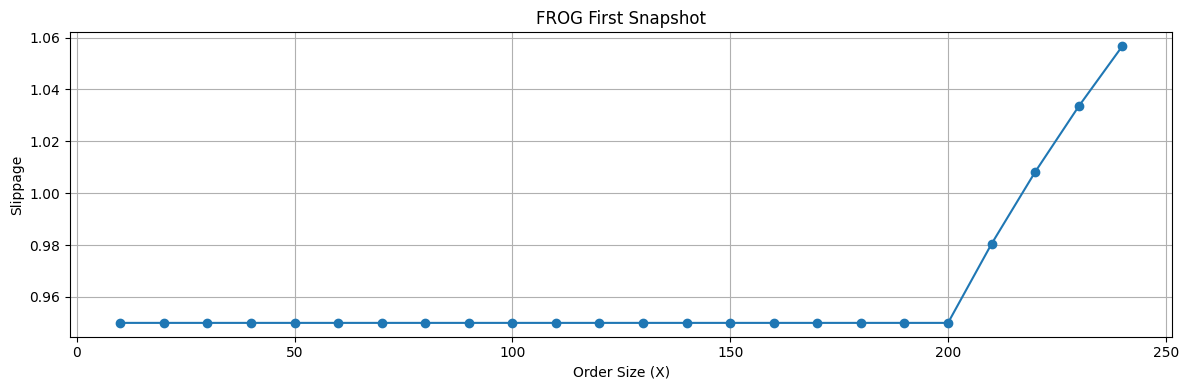


[CRWV] average linear slippage beta: 0.0001324992
[CRWV] average R^2 using average beta across all snapshots: -4212.7015


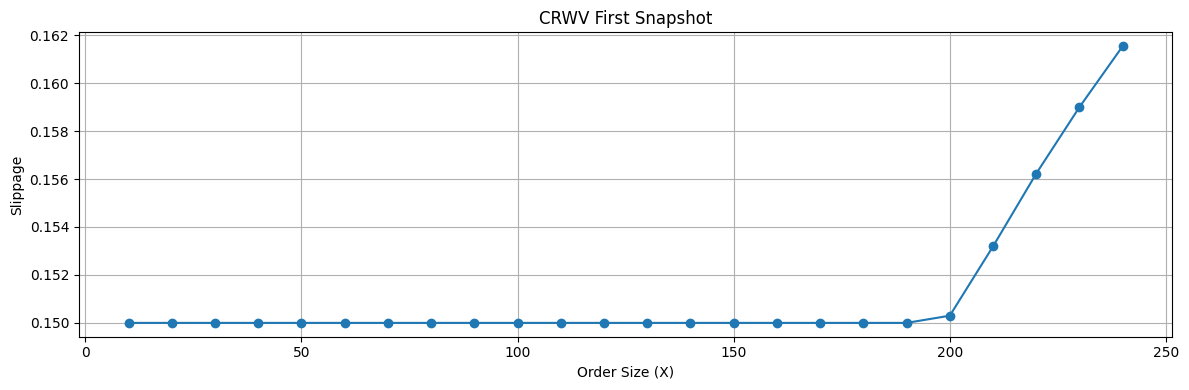

In [36]:
for (LOB,ticker) in Data:

  # keep the first snapshot for every minute
  LOB['time'] = LOB['ts_event'].dt.floor('min')
  LOB_snapshot = LOB.sort_values('ts_event').groupby('time', as_index=False).first()

  # calculate the mid price
  LOB_snapshot['mid_price'] = (LOB_snapshot['bid_px_00'] + LOB_snapshot['ask_px_00']) / 2

  betas = []
  all_slippages = []
  all_X = []
  r2_average_beta_list = []

  X_range = np.arange(10, 250, 10)  # here change the amount of orders

  # Iterare over all one-minute trading period for each ticker
  for _, row in LOB_snapshot.iterrows():
      ask_prices = [row[f'ask_px_0{i}'] for i in range(10)]
      ask_sizes = [row[f'ask_sz_0{i}'] for i in range(10)]
      mid_price = row['mid_price']

      slippages = []
      valid_X = []
      for X in X_range:
          s = compute_slippage(ask_prices, ask_sizes, mid_price, X)
          if s is not None:
              slippages.append(s)
              valid_X.append(X)

      # here do a linear regression to estimate beta
      if len(valid_X) > 3:
          reg = LinearRegression()
          reg.fit(np.array(valid_X).reshape(-1, 1), slippages)
          beta_t = reg.coef_[0]
          betas.append(beta_t)

          all_slippages.append(slippages)
          all_X.append(valid_X)
      else:
          betas.append(np.nan)
          all_slippages.append([])
          all_X.append([])

  # here average betas
  LOB_snapshot['beta'] = betas
  avg_beta = np.nanmean(betas)
  print(f"\n[{ticker}] average linear slippage beta: {avg_beta:.10f}")

  # here use the average beta in each regression to calculate R^2 and average R^2
  for Xs, sls in zip(all_X, all_slippages):
    if len(Xs) > 3:
        y_true = sls
        y_pred = [avg_beta * x for x in Xs]
        r2 = r2_score(y_true, y_pred)
        r2_average_beta_list.append(r2)

  avg_r2 = np.nanmean(r2_average_beta_list)
  print(f"[{ticker}] average R^2 using average beta across all snapshots: {avg_r2:.4f}")


  plt.figure(figsize=(12, 4))
  plt.plot(all_X[0], all_slippages[0], marker='o')
  plt.title(f'{ticker} First Snapshot')
  plt.xlabel('Order Size (X)')
  plt.ylabel('Slippage')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

We can see that the linear model performs poorly, as indicated by the negative average $R^2$, which suggests that the linear fit is worse than simply using the mean as a predictor.

**Then we try the Power Function Model**

In [35]:
for LOB, ticker in Data:

    LOB['time'] = LOB['ts_event'].dt.floor('min')
    LOB_snapshot = LOB.sort_values('ts_event').groupby('time', as_index=False).first()
    LOB_snapshot['mid_price'] = (LOB_snapshot['bid_px_00'] + LOB_snapshot['ask_px_00']) / 2

    alphas = []
    gammas = []
    r2_list = []
    all_slippages = []
    all_X = []

    X_range = np.arange(10, 250, 10)

    for _, row in LOB_snapshot.iterrows():
        ask_prices = [row[f'ask_px_0{i}'] for i in range(10)]
        ask_sizes = [row[f'ask_sz_0{i}'] for i in range(10)]
        mid_price = row['mid_price']

        slippages = []
        valid_X = []
        for X in X_range:
            s = compute_slippage(ask_prices, ask_sizes, mid_price, X)
            if s is not None and s > 0:
                slippages.append(s)
                valid_X.append(X)

        if len(valid_X) > 3:
            log_X = np.log(valid_X).reshape(-1, 1)
            log_slip = np.log(slippages)

            reg = LinearRegression()
            reg.fit(log_X, log_slip)

            gamma_t = reg.coef_[0]
            log_alpha_t = reg.intercept_
            alpha_t = np.exp(log_alpha_t)

            gammas.append(gamma_t)
            alphas.append(alpha_t)
            all_slippages.append(slippages)
            all_X.append(valid_X)

            # R² for this snapshot
            pred_log_slip = reg.predict(log_X)
            r2 = r2_score(log_slip, pred_log_slip)
            r2_list.append(r2)
        else:
            gammas.append(np.nan)
            alphas.append(np.nan)
            r2_list.append(np.nan)
            all_slippages.append([])
            all_X.append([])

    # average the parameters
    avg_alpha = np.nanmean(alphas)
    avg_gamma = np.nanmean(gammas)
    avg_r2 = np.nanmean(r2_list)

    print(f"\n[{ticker}] average alpha: {avg_alpha:.6e}")
    print(f"[{ticker}] average gamma: {avg_gamma:.4f}")
    print(f"[{ticker}] average R² (log-log fit): {avg_r2:.4f}")


[SOUN] average alpha: 5.149690e-03
[SOUN] average gamma: 0.0090
[SOUN] average R² (log-log fit): 0.9736

[FROG] average alpha: 4.239452e-02
[FROG] average gamma: 0.0765
[FROG] average R² (log-log fit): 0.7411

[CRWV] average alpha: 5.227106e-02
[CRWV] average gamma: 0.1433
[CRWV] average R² (log-log fit): 0.7544


Compared to the linear model, the power function model shows a significant improvement in performance. The model effectively captures the nonlinear nature of market impact, that large orders tend to "eat into the book" and incur increasingly higher costs. However, a key limitation is that the model's performance can degrade substantially if the parameters are not accurately estimated, as even small errors can lead to large deviations in predicted slippage.

**Further Improvement Consideration**:  We may try a polynomical model or machine learning based model

